In [1]:
# Basic set-up
p = 3       # Choose the prime p to calculate with
f = 1       # The degree of the residual field extension
e = 2       # The ramification index
q = p^f

# Define the p-adic field and its ring of integers
o_L.<Pi> = Zp(3, prec=300, type='capped-rel', print_mode='series').ext(x^2-3)
L.<Pi> = Qp(3, prec=300, type='capped-rel', print_mode='series').ext(x^2-3)

# Do linear algebra over the ring of polynomials L[X] in one variable X with coefficients in the field L:
L_X.<X> = L[]
L_Y.<Y> = L[]
v = L.valuation()

from time import process_time

# Decorator to record execution time
def time_this(func, name=None):
    if name is None:
        name = func.__name__
    
    
    def wrap(*args, **kwargs):
        _start = process_time()
        result = func(*args, **kwargs)
        _end   = process_time()
        
        print(f"{_end-_start : .2f} sec: {name}")
        return result

    return wrap

# The subroutine Dmatrix calculates the following sparse matrix of coefficients.
# Let D[k,n] be equal to k! times the coefficient of Y^k in the polynomial P_n(Y). 
# I compute this using the useful and easy recursion formula 
#      D[k,n] = \sum_{r \geq 0} \pi^{-r} D[k-1,n-q^r] 
# that can be derived from Laurent’s Prop 1.20 of "outline9".
# The algorithm is as follows: first make a zero matrix with S rows and columns (roughly, S is (q-1)*Size), 
# then quickly populate it one row at a time, using the recursion formula.

def Dmatrix(S):
    D = matrix(L, S,S)
    D[0,0] = 1
    for k in range(1,S):
        for n in range(k,S):
            r = 0
            while n >= q^r:
                D[k,n] = D[k,n] + D[k-1,n-q^r]/Pi^r  # the actual recursion 
                r = r+1
    return D


# \Tau^{(m)} in Definition 10.10 of "bounded21":
def TauMatrix(Size, m):
    D = Dmatrix((q - 1) * (Size + 1))
    R = matrix(L, Size,Size, lambda x,y: D[m + (q-1)*x, m + (q-1)*y])

    # Define a diagonal matrix:
    Diag = matrix(L_X, Size,Size, lambda x,y: kronecker_delta(x,y) * X^x)

    # Compute the inverse of R:
    S = R.inverse()    

    # Compute the matrix Tau using Lemma 10.11 in "bounded21":
    Tau = S * Diag * R
    
    return Tau

def underscore(m, i):
    return m + i*(q-1)

# Compute the matrix ( \sigma_{ij}(Y) ) using Proposition 10.6 of "bounded21":
def sigmaMatrix(Size):
    sigma = matrix(L_Y, Size,Size)
    
    for m in [0 .. q-2]:
        Tau = TauMatrix((q-1)*(Size+1), m)
        j = 0
        while underscore(m, j) < Size:
            i = 0
            while underscore(m, i) < Size:
                sigma[underscore(m, i), underscore(m, j)] = Y^m * Tau[i, j](Y^(q-1))
                i += 1
            j += 1
    
    return sigma

# Construct a vwdwo sequence as per Proposition II.2.3 of Cahen-Chabert:
def vwdwo(N):
    u_ = [i for i in range(q)]  # only for L totally ramified
    
    def u(n):
        return o_L(sum(
            u_[n_i] * Pi^i
            for i, n_i in enumerate(Integer(n).digits(base=q))
        ))
    
    return [u(n) for n in [0 .. N]]

# Compute a regular basis (f_n) as per Theorem II.2.7 of Cahen-Chabert:
def regular_basis(N):
#     u = vwdwo(N)
    
    def f(n):
        if n == 0:
            return L_Y(1)
        else:
            return prod((Y - u[k]) / (u[n] - u[k]) for k in [0 .. n-1])
    
    return [f(n) for n in [0 .. N]]


u = vwdwo(100)
fs = regular_basis(100)


# Find b_i in o_L such that P = \sum b_i f_i:
def regular_basis_coeffs_for(P):
    n = P.degree(Y)
    bs = [0] * (n + 1)
    for i in [0 .. n]:
        # Since f_i(u_i) = 1; f_j(u_i) = 0 for all j \geq i:
        bs[i] = P(u[i]) - sum(bs[j] * fs[j](u[i]) for j in [0 .. i-1])
    return vector(o_L, bs)

def sigma_coeffs_for_basis(M):
    m = M + 1
    n = (M+2) * (M+1) / 2
    B = Matrix(o_L, m, n)
    
    @time_this
    def compute_sigma():
        return sigmaMatrix(M + 1)
    sigma = compute_sigma()

    @time_this
    def fill_B(B):
        nb_col = 0
        
        for j in [0 .. M]:
            for i in [0 .. j]:
                bs = regular_basis_coeffs_for(sigma[i, j])
                # Only fill in non-zero columns:
                if any(b != 0 for b in bs):                
                    for k, b in enumerate(bs):
                        B[k, nb_col] = b  # Columns of B are the generators
                    nb_col += 1
        
        return B[:, 0:nb_col]
    B = fill_B(B)

    @time_this

    def get_SNF():
        return B.smith_form() 
    A, P, Q = get_SNF()   # A = P B Q

    C = Matrix(L, A[:, 0:M+1])  # A = [C|0]
    
#    return ~P * C  # S_M = o_L . f (~P * A)    
    return ~C * P  # nth column is (\beta_{0,n}, ..., \beta_{M,n})^T
                   # where f_n = \sum_{k=0}^M \beta_{k,n} g_k
                   # and g_0, ..., g_M is a basis for the o_L module

        
def sigma_coeffs_for_basis_iter(M):
    with open('w_Qp.txt', 'w') as file:
        file.write('')

    
    depths = Matrix(QQ, M+1, M+1)  # depths[M, j] = w(M, j), defined below
    depths[0, 0] = 0
    
    sigma = time_this(sigmaMatrix)(M + 1)
    
    m = 0
    P_0 = Q_0 = B = Matrix(o_L, [[1]])
   
    while m < M:
        m += 1
        print()
        print(m)
        
        @time_this
        def fill_B():
            B_new = Matrix(o_L, m+1, binomial(m+2, 2))
            B_new[:m, :B.ncols()] = B
            nb_col = B.ncols()
            for i in [0 .. m]:
                bs = regular_basis_coeffs_for(sigma[i, m])
                if any(b != Integer(0) for b in bs):
                    B_new[:len(bs), nb_col] = bs
                    nb_col += 1
            B_new = B_new[:, :nb_col]
            return nb_col, B_new
        nb_col, B = fill_B()
        
        P_ = block_matrix([ [P_0, 0], [0, identity_matrix(1)] ])  # GL_{m+1}
        Q_ = block_matrix([ [Q_0, 0], [0, identity_matrix(nb_col - Q_0.nrows())] ])  # GL_{nb_col}
        B_ = Matrix(o_L, P_ * B * Q_)
        
        A, P, Q = time_this(lambda B: B.smith_form(), f"SNF M={m}")(B_)  # A = P B_ Q = P_ P B Q_ Q

        P_0 = P * P_
        Q_0 = Q_ * Q

        # For each M, compute the vector of valuations (w(M,j), j=0..M), where:
        # w(M,j) is the least non-negative rational number such that p^{w(M,j)} . f_j lies in S_M
        Z = ~(A[:, :m+1]) * P_0
        depths[m, :m+1] = vector([
            -min(v(x) for x in Z[:, j].list()) 
            for j in [0 .. m]
        ])
        with open('w_Qp.txt', 'a') as file:
            file.write(str(depths[m, :m+1].list()) + '\n')
        
#         print(depths[m, :m+1].list())
    
#     return ~(A[:, :m+1]) * P_0 # nth column is (\beta_{0,n}, ..., \beta_{M,n})^T
    return depths


In [2]:
sigma_coeffs_for_basis_iter(100)

 182.67 sec: sigmaMatrix

1
 0.07 sec: fill_B
 0.00 sec: SNF M=1

2
 0.01 sec: fill_B
 0.00 sec: SNF M=2

3
 0.01 sec: fill_B
 0.01 sec: SNF M=3

4
 0.02 sec: fill_B
 0.01 sec: SNF M=4

5
 0.04 sec: fill_B
 0.02 sec: SNF M=5

6
 0.07 sec: fill_B
 0.03 sec: SNF M=6

7
 0.10 sec: fill_B
 0.04 sec: SNF M=7

8
 0.13 sec: fill_B
 0.05 sec: SNF M=8

9
 0.14 sec: fill_B
 0.07 sec: SNF M=9

10
 0.18 sec: fill_B
 0.07 sec: SNF M=10

11
 0.26 sec: fill_B
 0.08 sec: SNF M=11

12
 0.28 sec: fill_B
 0.12 sec: SNF M=12

13
 0.42 sec: fill_B
 0.12 sec: SNF M=13

14
 0.44 sec: fill_B
 0.13 sec: SNF M=14

15
 0.52 sec: fill_B
 0.17 sec: SNF M=15

16
 0.62 sec: fill_B
 0.19 sec: SNF M=16

17
 0.81 sec: fill_B
 0.21 sec: SNF M=17

18
 0.84 sec: fill_B
 0.28 sec: SNF M=18

19
 1.05 sec: fill_B
 0.31 sec: SNF M=19

20
 1.27 sec: fill_B
 0.40 sec: SNF M=20

21
 1.40 sec: fill_B
 0.44 sec: SNF M=21

22
 1.71 sec: fill_B
 0.48 sec: SNF M=22

23
 1.94 sec: fill_B
 0.51 sec: SNF M=23

24
 1.95 sec: fill_B
 0.62

101 x 101 dense matrix over Rational Field (use the '.str()' method to see the entries)

In [3]:
M = 100

depths = Matrix(QQ, M+1, M+1)
with open('w_Qp.txt', 'r') as data:
    for i, raw_line in enumerate(data.readlines()):
        line = vector(eval(raw_line))
        depths[i+1, :len(line)] = line
depths

101 x 101 dense matrix over Rational Field (use the '.str()' method to see the entries)

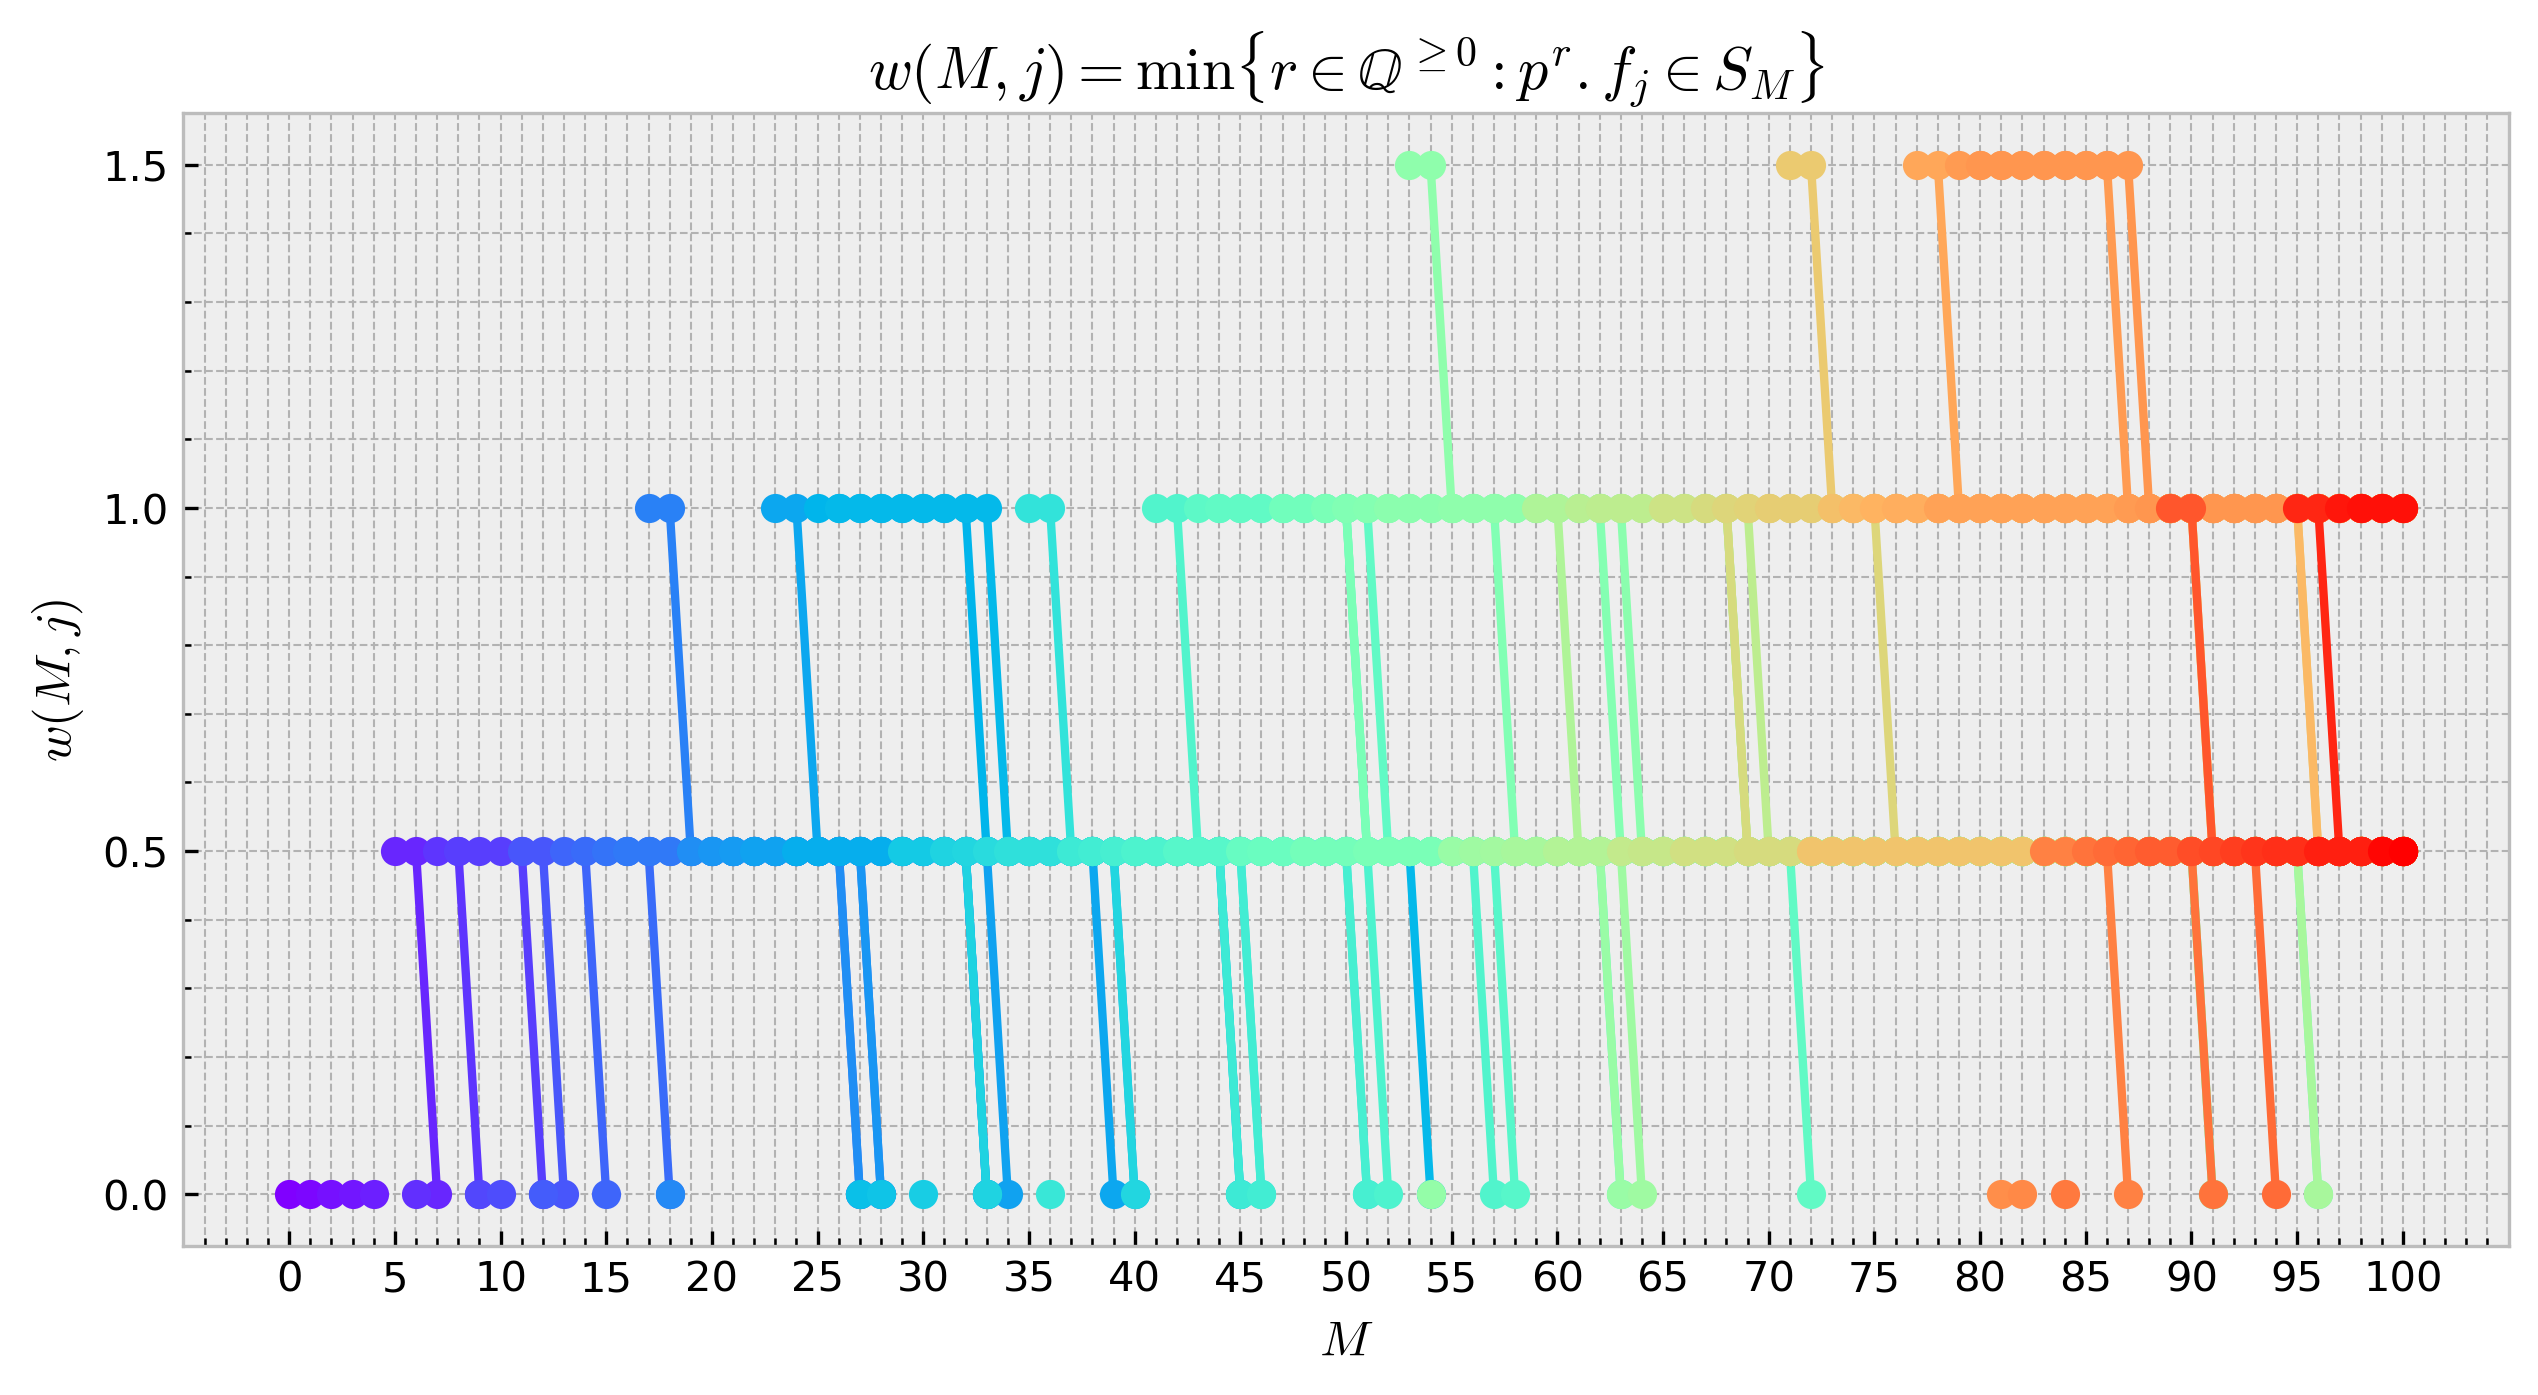

In [50]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib

matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = (10, 5)

plt.style.use('bmh')


plt.figure()
color=iter(cm.rainbow(np.linspace(0, 1, M+1)))
for j in [0 .. M]:
    c = next(color)
    ws = depths[j:, j].list()
    if 0 in ws:
        ws = ws[:ws.index(0) + 1]  # crop further zeroes 
    xs = range(j, j + len(ws))
    plt.plot(xs, ws, '-o', c=c)
#     plt.text(j-0.5, ws[0] + (j%5)/5 * 0.1, str(j), size='small')
plt.xlabel("$M$")
plt.ylabel("$w(M, j)$")
plt.title(r"$w(M, j) = \min\{ r \in \mathbb{Q}^{\geq 0} : p^r . f_j \in S_M \}$")
plt.xticks(range(0, M+1, 5))
plt.yticks([0, 0.5, 1, 1.5])
plt.minorticks_on()
plt.grid(which='minor')
plt.show()

In [36]:
js = []
j_s = []
Cs = []
Xs = []

for j in [0 .. M]:
    ws = depths[j:, j].list()
    if 0 in ws:
        js.append(j)
        Cs.append(ws.index(0) + j)
        Xs.append(ws.index(0))
    else:
        j_s.append(j)


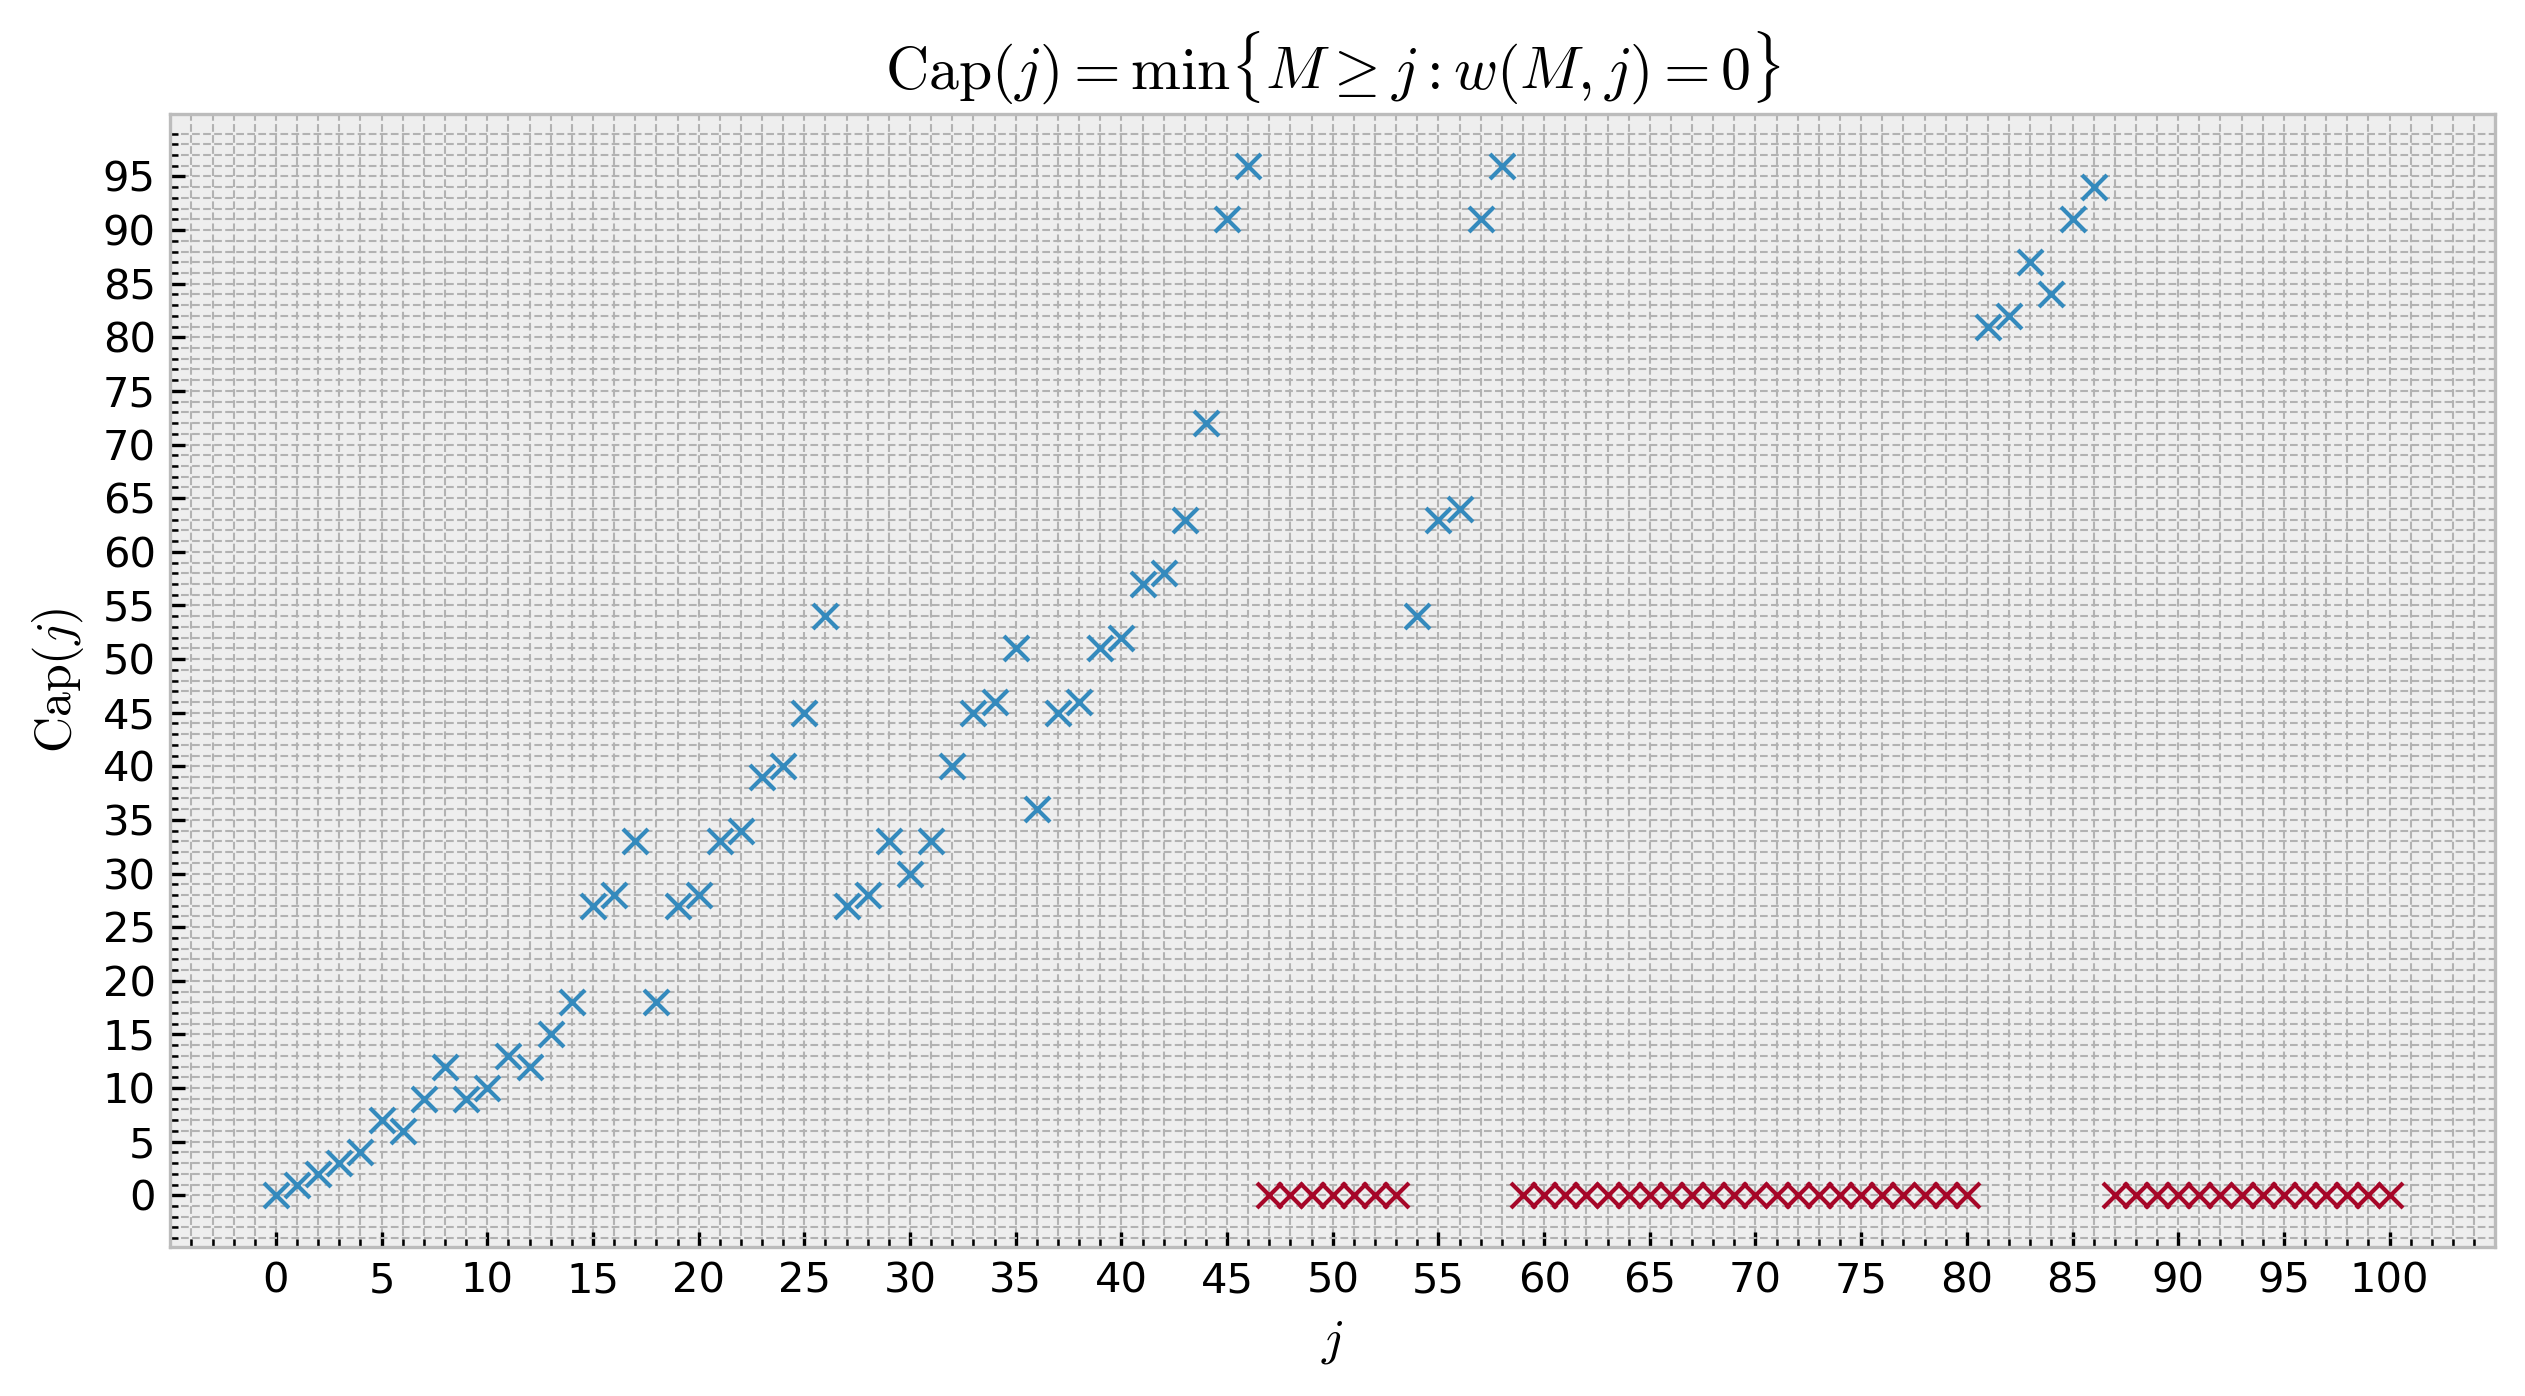

In [51]:
plt.plot(js, Cs, 'x')
plt.plot(j_s, [0]*len(j_s), 'x')
plt.xticks(range(0, M+1, 5))
plt.yticks(range(0, max(Cs)+1, 5))
plt.xlabel("$j$")
plt.ylabel(r"$\mathrm{Cap}(j)$")
plt.title(r"$\mathrm{Cap}(j) = \min\{M \geq j : w(M, j) = 0\}$")

plt.minorticks_on()
plt.grid(which='minor')
plt.show()

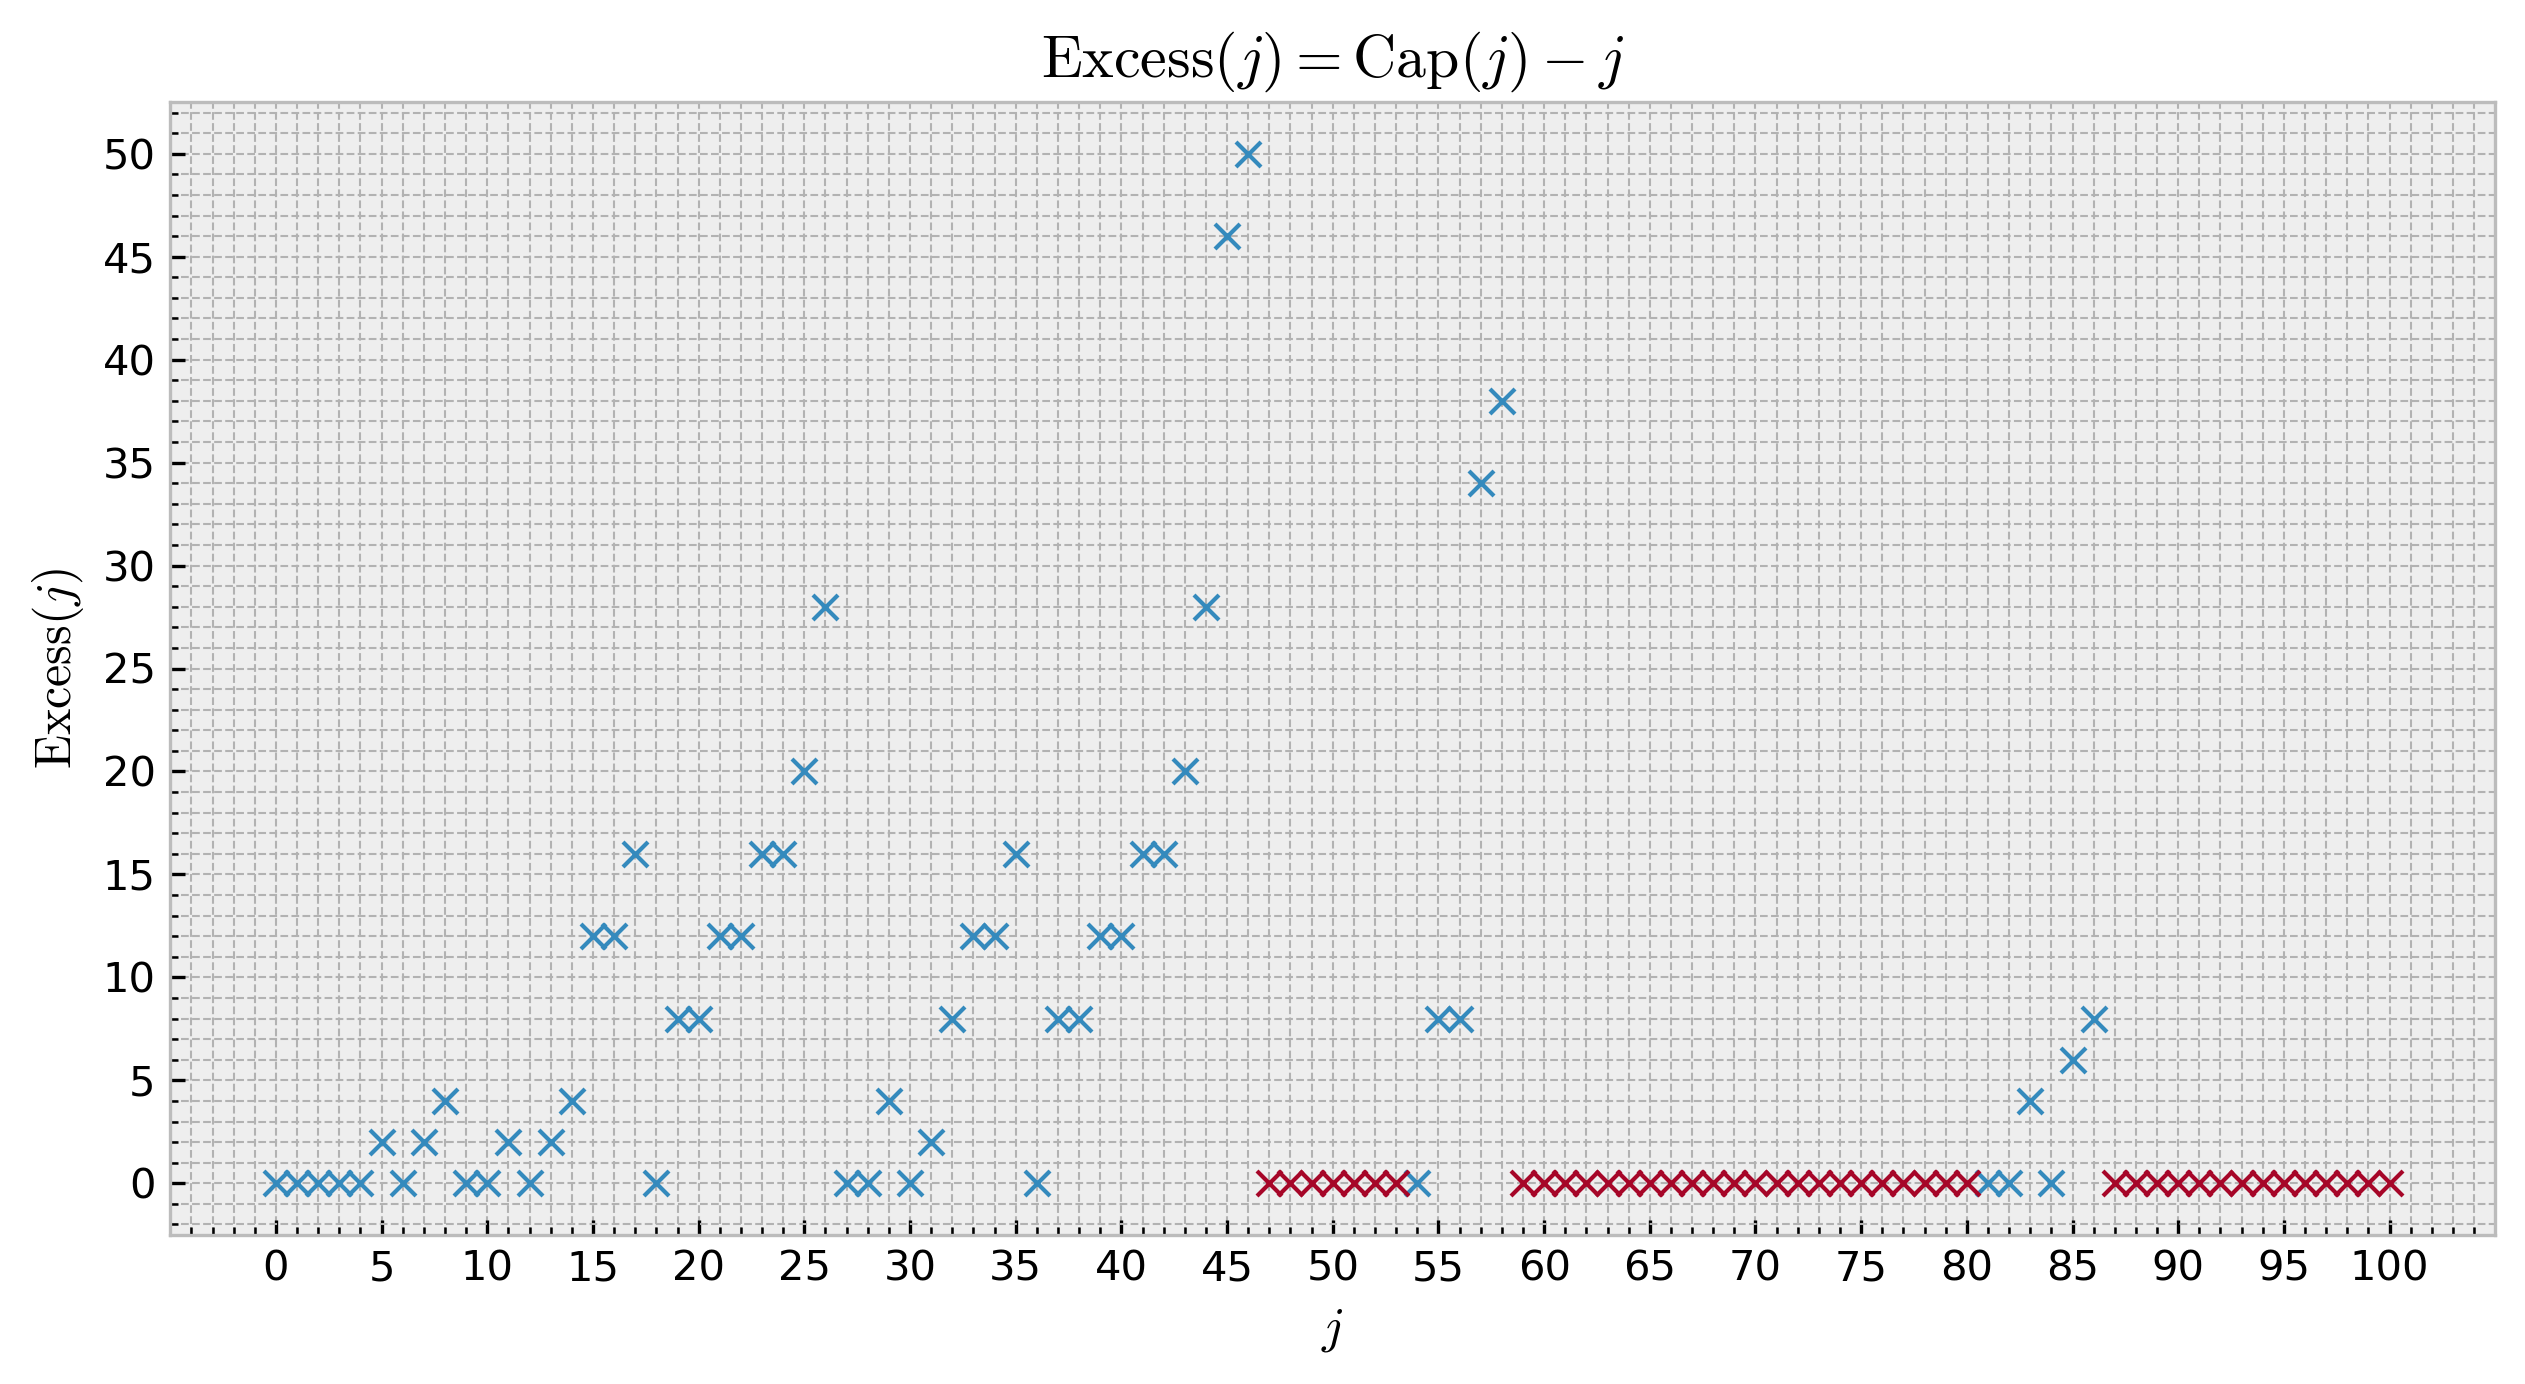

In [52]:
plt.plot(js, Xs, 'x')
plt.plot(j_s, [0]*len(j_s), 'x')
plt.xticks(range(0, M+1, 5))
plt.yticks(range(0, max(Xs)+1, 5))
plt.xlabel("$j$")
plt.ylabel(r"$\mathrm{Excess}(j)$")
plt.title(r"$\mathrm{Excess}(j) = \mathrm{Cap}(j) - j$")

plt.minorticks_on()
plt.grid(which='minor')
plt.show()

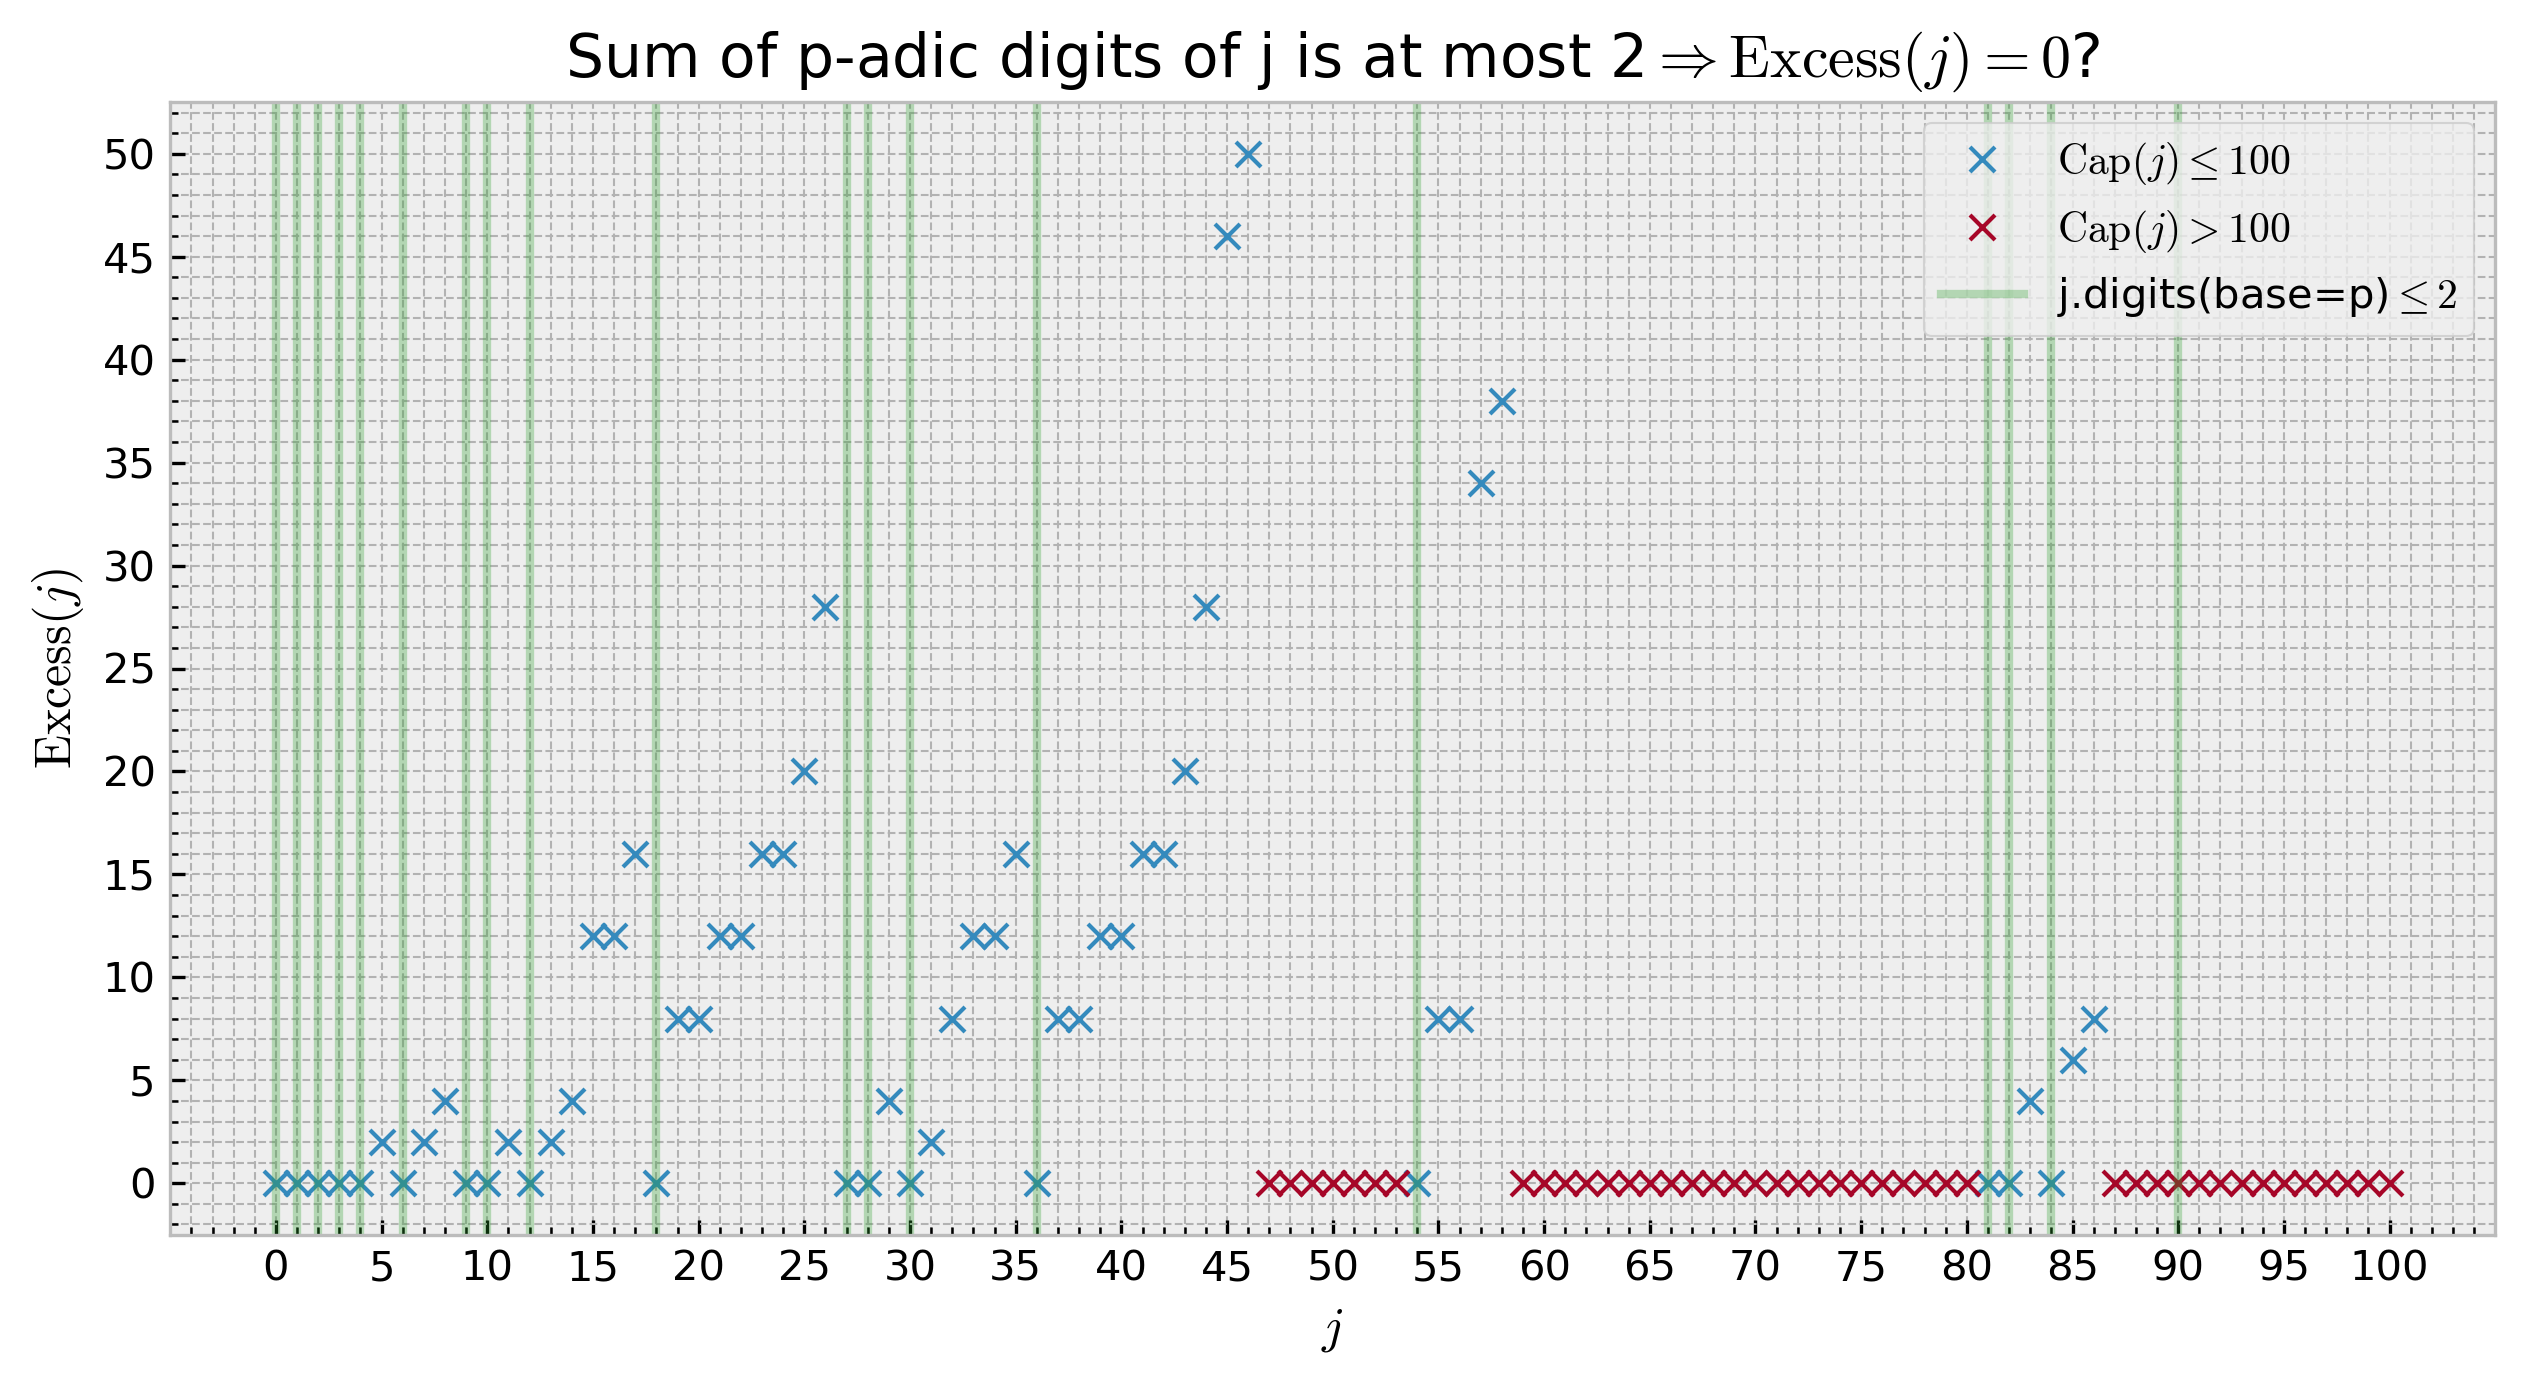

In [74]:
plt.plot(js, Xs, 'x')
plt.plot(j_s, [0]*len(j_s), 'x')

for j in [0 .. M]:
    if sum(j.digits(base=p)) <= 2:
        plt.axvline(x=j, c='#2ca02c', alpha=.3)
plt.legend([r"$\mathrm{Cap}(j) \leq 100$", r"$\mathrm{Cap}(j) > 100$", r"j.digits(base=p)$\leq 2$"])
        
plt.xticks(range(0, M+1, 5))
plt.yticks(range(0, max(Xs)+1, 5))
plt.xlabel("$j$")
plt.ylabel(r"$\mathrm{Excess}(j)$")
plt.title(r"Sum of p-adic digits of j is at most 2$\Rightarrow \mathrm{Excess}(j) = 0$?")

plt.minorticks_on()
plt.grid(which='minor')
plt.show()